In [138]:
# Libraries required

# Data
import pandas as pd
import numpy as np

#Statistics
from scipy.stats import chi2_contingency, mannwhitneyu, kruskal

# Visualization
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.transforms import Bbox
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
palette = plt.get_cmap('Set2')
plt.style.use('seaborn-darkgrid')

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Data loading

df = pd.read_csv('FRU_analytics_test_task.csv', parse_dates=['EventTime'])

print(f'Rows: {df.shape[0]}')

df.head()

Rows: 58770


,ClientID,EventTime,EventType,DonationType,AmountInUSD,tag
0,885410877,2022-07-20 00:00:23,checkoutView,NaN,NaN,control
1,859319263,2022-07-20 00:00:48,checkoutView,NaN,NaN,test
2,480984859,2022-07-20 00:00:58,checkoutView,NaN,NaN,control
3,204664871,2022-07-20 00:01:00,checkoutView,NaN,NaN,test
4,859319263,2022-07-20 00:01:05,checkoutView,NaN,NaN,test


In [3]:
# Missing values

df.isnull().sum()

ClientID            0
EventTime           0
EventType           0
DonationType    53406
AmountInUSD     53406
tag              5364
dtype: int64

___
__Наблюдение:__ В данных присутствует большое количество выбросов. Пропуски в полях `DonationType` и `AmountInUSD` можно объяснить тем, что данное тип события (checkoutView), не является созданием доната, а вот пропуски в поле `tag` объяснить сложнее. Можно заметить, что сумма пропусков по полям `DonationType` (или `AmountInUSD`) и `tag` совпадает с общим числом строк в датафрейме.
___

In [16]:
# Sample

df[df['ClientID'].eq(204664871)]

,ClientID,EventTime,EventType,DonationType,AmountInUSD,tag
3,204664871,2022-07-20 00:01:00,checkoutView,NaN,NaN,test
14,204664871,2022-07-20 00:03:50,charge,one-time,200.0,NaN
18,204664871,2022-07-20 00:04:27,checkoutView,NaN,NaN,test
22,204664871,2022-07-20 00:05:01,charge,one-time,28.0,NaN


___
__Наблюдение:__ Один и тот же клиент может присутствовать в данных несколько раз, более того поле `tag` заполняется только для события checkoutView.
___

In [82]:
sum(df[df['tag'].isin(('control', 'test'))].groupby('ClientID')['tag'].agg(set).apply(lambda x: len(x)) > 1)

0

____
__Наблюдение:__ Одному и тому же клиенту соответствует единственное значение из поля `tag`.
____

In [36]:
# Data transforming 1

# Сортируем по дате события 'checkoutView'
df_1 = df[df['EventType'].eq('checkoutView')][['ClientID', 'EventTime', 'tag']]\
      .sort_values('EventTime', ignore_index=True)

# К каждому клиенту подтягиваем дату его следуещего события 'checkoutView'
df_1['Next_EventTime'] = df_1.groupby(['ClientID', 'tag'])['EventTime'].shift(-1)

# Пропуски заполняем текущей датой
df_1.fillna(pd.Timestamp.now(), inplace=True)

print(f'Rows: {df_1.shape[0]}')

df_1.head()

Rows: 53406


,ClientID,EventTime,tag,Next_EventTime
0,885410877,2022-07-20 00:00:23,control,2022-07-20 00:01:19.000000
1,859319263,2022-07-20 00:00:48,test,2022-07-20 00:01:05.000000
2,480984859,2022-07-20 00:00:58,control,2024-03-06 11:37:21.608804
3,204664871,2022-07-20 00:01:00,test,2022-07-20 00:04:27.000000
4,859319263,2022-07-20 00:01:05,test,2024-03-06 11:37:21.608804


In [60]:
# Sample

df_1[df_1['ClientID'].eq(204664871)]

,ClientID,EventTime,tag,Next_EventTime
3,204664871,2022-07-20 00:01:00,test,2022-07-20 00:04:27.000000
17,204664871,2022-07-20 00:04:27,test,2024-03-06 11:37:21.608804


In [66]:
# Data transforming 2

# Собираем все события 'charge'
df_2 = df[df['EventType'].eq('charge')][['ClientID', 'EventTime', 'DonationType', 'AmountInUSD']]

print(f'Rows: {df_2.shape[0]}')

df_2.head()

Rows: 5364


,ClientID,EventTime,DonationType,AmountInUSD
14,204664871,2022-07-20 00:03:50,one-time,200.0
21,480984859,2022-07-20 00:04:49,one-time,110.0
22,204664871,2022-07-20 00:05:01,one-time,28.0
36,162105910,2022-07-20 00:07:57,one-time,50.0
56,768115744,2022-07-20 00:11:06,one-time,10.0


In [67]:
# Sample

df_2[df_2['ClientID'].eq(204664871)]

,ClientID,EventTime,DonationType,AmountInUSD
14,204664871,2022-07-20 00:03:50,one-time,200.0
22,204664871,2022-07-20 00:05:01,one-time,28.0


In [78]:
# Data transforming 3

# Подтягиваем к каждому событию 'checkoutView' событие 'charge'
df_3 = df_1.merge(
                 df_2.rename(columns={'EventTime': 'charge_EventTime'})
                ,on='ClientID'
                ,how='inner'
        )

# Оставляем только те события 'charge', которые произошли между двумя соседними событиями 'checkoutView'
df_3 = df_3[
          (df_3['charge_EventTime'] > df_3['EventTime'])
        & (df_3['charge_EventTime'] < df_3['Next_EventTime'])
    ]

print(f'Rows: {df_3.shape[0]}')

df_3.head()

Rows: 5364


,ClientID,EventTime,tag,Next_EventTime,charge_EventTime,DonationType,AmountInUSD
0,480984859,2022-07-20 00:00:58,control,2024-03-06 11:37:21.608804,2022-07-20 00:04:49,one-time,110.0
1,204664871,2022-07-20 00:01:00,test,2022-07-20 00:04:27.000000,2022-07-20 00:03:50,one-time,200.0
4,204664871,2022-07-20 00:04:27,test,2024-03-06 11:37:21.608804,2022-07-20 00:05:01,one-time,28.0
5,162105910,2022-07-20 00:04:06,control,2024-03-06 11:37:21.608804,2022-07-20 00:07:57,one-time,50.0
6,768115744,2022-07-20 00:08:16,test,2024-03-06 11:37:21.608804,2022-07-20 00:11:06,one-time,10.0


In [79]:
# Sample

df_3[df_3['ClientID'].eq(204664871)]

,ClientID,EventTime,tag,Next_EventTime,charge_EventTime,DonationType,AmountInUSD
1,204664871,2022-07-20 00:01:00,test,2022-07-20 00:04:27.000000,2022-07-20 00:03:50,one-time,200.0
4,204664871,2022-07-20 00:04:27,test,2024-03-06 11:37:21.608804,2022-07-20 00:05:01,one-time,28.0


In [84]:
# Data transforming 4

# Объединиям с теми событиями 'checkoutView', после которых не было события 'charge'
df_corrected = df_1.merge(df_3, on=['ClientID', 'EventTime', 'Next_EventTime', 'tag'], how='left')\
                    [['ClientID', 'EventTime', 'tag', 'charge_EventTime', 'DonationType', 'AmountInUSD']]

# Проставляем бинарный флаг
df_corrected['IsCharge'] = (df_corrected['AmountInUSD'] > 0).astype(np.int8)

print(f'Rows: {df_corrected.shape[0]}')

df_corrected.head()

Rows: 53406


,ClientID,EventTime,tag,charge_EventTime,DonationType,AmountInUSD,IsCharge
0,885410877,2022-07-20 00:00:23,control,NaT,NaN,NaN,0
1,859319263,2022-07-20 00:00:48,test,NaT,NaN,NaN,0
2,480984859,2022-07-20 00:00:58,control,2022-07-20 00:04:49,one-time,110.0,1
3,204664871,2022-07-20 00:01:00,test,2022-07-20 00:03:50,one-time,200.0,1
4,859319263,2022-07-20 00:01:05,test,NaT,NaN,NaN,0


In [89]:
# Features

idx_col = 'ClientID'
target = 'tag'
num_cols = ['IsCharge', 'AmountInUSD']
cat_col = 'DonationType'

In [124]:
# Visualization

paper = go.Figure()
 
palette_1 = px.colors.sequential.Viridis_r[1:]
palette_2 = px.colors.sequential.Viridis[1:]

data = df_corrected[[idx_col, target]].drop_duplicates()[target].value_counts(normalize=True)
freq = df_corrected[[idx_col, target]].drop_duplicates()[target].value_counts()
cat_freq = {name: f'{name} (#{freq[name]})' for name in freq.index}

max_ratio = data.values.max()
    
colors = [palette_1[0]] * data.shape[0]
colors[np.where(data == max_ratio)[0][0]] = palette_2[0]

paper.add_trace(
            go.Bar(
                 x=data.index.map(cat_freq)
                ,y=data.values
                ,text=data.apply(lambda x: f'{x:.1%}')
                ,textposition='auto'
                ,orientation='v'
                ,marker_color=colors
                ,marker_line_color='black'
                ,marker_line_width=.8
                ,opacity=.8
            )
)
    
paper.update_layout(title={'text': f'Количество клиентов по группам'}, title_x=0.5)

# paper.write_html('количество_клиентов_по_группам.html')

paper.show()

____
__Наблюдение:__ Группы распределены равномерно по количеству клиентов.
____

<div class="alert alert-warning">
Предлагаю рассмотреть следующие метрики:
    
* Конверсия из просмотра в донат. Эту метрику можно считать целевой для данного AB-теста. Имеет смысл рассмотреть ее отдельно в контекте разовых пожертвований (это то, на что было непосредственно направлено изменение) и в контексте всех пожертований;
* Средний размер доната. Отсутствие предварительного выбора суммы доната может снизить эту метрику в независимости от конверсии. Имеет смысл также рассмотреть в контекте разовых пожертвований и в контексте всех пожертований;
* Доля разовых пожертований среди всех пожертований. Внедренное изменение может оказать влияние соотношение разовых пожертвований и месячных пожертвований (а может и не оказать).
</div>

In [148]:
metrics = [
         'КонверсияИзПросмотраВДонат(ДляРазовыхПожертвований)'
        ,'КонверсияИзПросмотраВДонат(ДляВсехПожертвований)'
        ,'СредняяСуммаДоната(ДляРазовыхПожертвований)'
        ,'СредняяСуммаДоната(ДляВсехПожертвований)'
        ,'ДоляРазовыхПожертвований'
]

In [149]:
# Metrics calculation

df_agg = pd.concat(
                [
                 df_corrected[df_corrected[cat_col].eq('one-time') | df_corrected[cat_col].isnull()]\
                    .groupby(target)[num_cols[0]].agg(['sum', 'count']).reset_index()\
                    .rename(columns={'sum': 'Nominator', 'count': 'Denominator'}).assign(Extra=None)\
                    .assign(Metric=metrics[0])
                    
                ,df_corrected\
                    .groupby(target)[num_cols[0]].agg(['sum', 'count']).reset_index()\
                    .rename(columns={'sum': 'Nominator', 'count': 'Denominator'}).assign(Extra=None)\
                    .assign(Metric=metrics[1])
                    
                ,df_corrected[df_corrected[cat_col].eq('one-time') | df_corrected[cat_col].isnull()]\
                    .groupby(target)[num_cols[1]].agg(['mean', list]).reset_index()\
                    .rename(columns={'mean': 'Nominator', 'list': 'Extra'}).assign(Denominator=1)\
                    .assign(Metric=metrics[2])\
                    [[target, 'Nominator', 'Denominator', 'Extra', 'Metric']]    
                    
                ,df_corrected\
                    .groupby(target)[num_cols[1]].agg(['mean', list]).reset_index()\
                    .rename(columns={'mean': 'Nominator', 'list': 'Extra'}).assign(Denominator=1)\
                    .assign(Metric=metrics[3])\
                    [[target, 'Nominator', 'Denominator', 'Extra', 'Metric']]   
                    
                ,df_corrected.groupby([target, cat_col])[idx_col].count().unstack().reset_index()\
                    .assign(Denominator=lambda x: x['one-time'] + x['recurring'])\
                    .rename(columns={'one-time': 'Nominator'}).assign(Extra=None)\
                    .assign(Metric=metrics[4])\
                    [[target, 'Nominator', 'Denominator', 'Extra', 'Metric']] 
                    
                ]
                ,ignore_index=True   
)

df_agg.head()

DonationType,tag,Nominator,Denominator,Extra,Metric
0,control,2484.000000,26538,None,КонверсияИзПросмотраВДонат(ДляРазовыхПожертвов...
1,test,2705.000000,26693,None,КонверсияИзПросмотраВДонат(ДляРазовыхПожертвов...
2,control,2588.000000,26642,None,КонверсияИзПросмотраВДонат(ДляВсехПожертвований)
3,test,2776.000000,26764,None,КонверсияИзПросмотраВДонат(ДляВсехПожертвований)
4,control,80.137681,1,"[nan, 110.0, nan, nan, nan, nan, 50.0, nan, na...",СредняяСуммаДоната(ДляРазовыхПожертвований)


In [150]:
# Visualization

paper = go.Figure()

palette_1 = px.colors.sequential.Viridis_r[1:]
palette_2 = px.colors.sequential.Viridis[1:]

start_col = metrics[0]
colors_1 = iter([palette_1[i] if i < len(palette_1) else palette_1[i % len(palette_1)] for i in range(len(metrics))])
colors_2 = iter([palette_2[i] if i < len(palette_2) else palette_2[i % len(palette_2)] for i in range(len(metrics))])

for col in metrics:   
    visible = False if col != start_col else True
    
    data = df_agg[df_agg['Metric'].eq(col)].assign(Ratio=lambda x: x['Nominator'] / x['Denominator']).reset_index()
    
    max_ratio = data['Ratio'].max()
    
    colors = [next(colors_1)] * data.shape[0]
    colors[data[data['Ratio'].eq(max_ratio)].index[0]] = next(colors_2)
    
    paper.add_trace(
                go.Bar(
                     x=data[target]
                    ,y=data['Ratio']
                    ,base='group'
                    ,text=np.round(data['Ratio'], 3)
                    ,textposition='auto'
                    ,orientation='v'
                    ,marker_color=colors
                    ,marker_line_color='black'
                    ,marker_line_width=.8
                    ,visible=visible
                    ,opacity=.8
                    ,name=col
                )
    )

mysteps = [None] * len(metrics)
for i, col in enumerate(metrics):
    tmp = [True if j in range(1 * i, 1 * i + 1) else False for j in range(len(paper.data))] 
    step = {
         'method': 'update'
        ,'args': [{'visible': tmp}, {'title.text': f'{col}', 'barmode': 'group'}]
        ,'label': col
    }
    mysteps[i] = step

sliders = [{
     'active': 10
    ,'currentvalue': {'prefix': ''}
    ,'pad': {'t': 100}
    ,'steps': mysteps
}]    
    
paper.update_layout(sliders=sliders, title={'text': f'{start_col}'}, title_x=0.5)

# paper.write_html('метрики_по_группам.html')

paper.show()

____
__Наблюдение:__
* Значение метрики `КонверсияИзПросмотраВДонат(ДляРазовыхПожертвований)` выше в группе `test`;
* Значение метрики `КонверсияИзПросмотраВДонат(ДляВсехПожертвований)` выше в группе `test`;
* Значение метрики `СредняяСуммаДоната(ДляРазовыхПожертвований)` выше в группе `control`;
* Значение метрики `СредняяСуммаДоната(ДляВсехПожертвований)` выше в группе `control`;
* Значение метрики `ДоляРазовыхПожертвований` выше в группе `test`.
____

In [151]:
p_value = .05 # Стандартное пороговое значение

In [152]:
print('Результаты теста Хи-квадрат\n') # Критерий для конверсионных метрик

df_agg[~df_agg['Metric'].isin((metrics[2], metrics[3]))]\
                    .groupby('Metric')\
                    .apply(lambda x: chi2_contingency(x[['Nominator', 'Denominator']])[1])\
                    .to_frame().rename(columns={0: 'p_value'})\
                    .assign(tmp=lambda x: x['p_value'] < p_value)\
                    .rename(columns={'tmp': f'p_value < {p_value}'})

Результаты теста Хи-квадрат



,p_value,p_value < 0.05
Metric,,
ДоляРазовыхПожертвований,0.712785,False
КонверсияИзПросмотраВДонат(ДляВсехПожертвований),0.023014,True
КонверсияИзПросмотраВДонат(ДляРазовыхПожертвований),0.006651,True


In [153]:
print('Результаты теста Манна-Уитни\n') # Критерий для неконверсионных метрик и произвольной формы распределения

df_agg[df_agg['Metric'].isin((metrics[2], metrics[3]))]\
                    .groupby('Metric')['Extra'].agg(list)\
                    .apply(lambda x: mannwhitneyu(*x)[1])\
                    .to_frame().rename(columns={'Extra': 'p_value'})\
                    .assign(tmp=lambda x: x['p_value'] < p_value)\
                    .rename(columns={'tmp': f'p_value < {p_value}'})

Результаты теста Манна-Уитни



,p_value,p_value < 0.05
Metric,,
СредняяСуммаДоната(ДляВсехПожертвований),0.0,True
СредняяСуммаДоната(ДляРазовыхПожертвований),0.0,True


____
__Вывод:__ На уровне значимости 5% получили следующую картину:
* По метрике `КонверсияИзПросмотраВДонат(ДляРазовыхПожертвований)` есть стат. значимые различия между группами;
* По метрике `КонверсияИзПросмотраВДонат(ДляВсехПожертвований)` есть стат. значимые различия между группами;
* По метрике `СредняяСуммаДоната(ДляРазовыхПожертвований)` есть стат. значимые различия между группами;
* По метрике `СредняяСуммаДоната(ДляВсехПожертвований)` есть стат. значимые различия между группами;
* По метрике `ДоляРазовыхПожертвований` стат. значимых различий обнаружить не удалось.
____

__Замечание:__ На всякий случай проверим, хватает ли нам наблюдений для текущих изменений целевой метрики (размер выборки определяется до проведения эксперимента, но у нас нет информации было ли это сделано, поэтому лучше оценить хотя бы порядок величин).

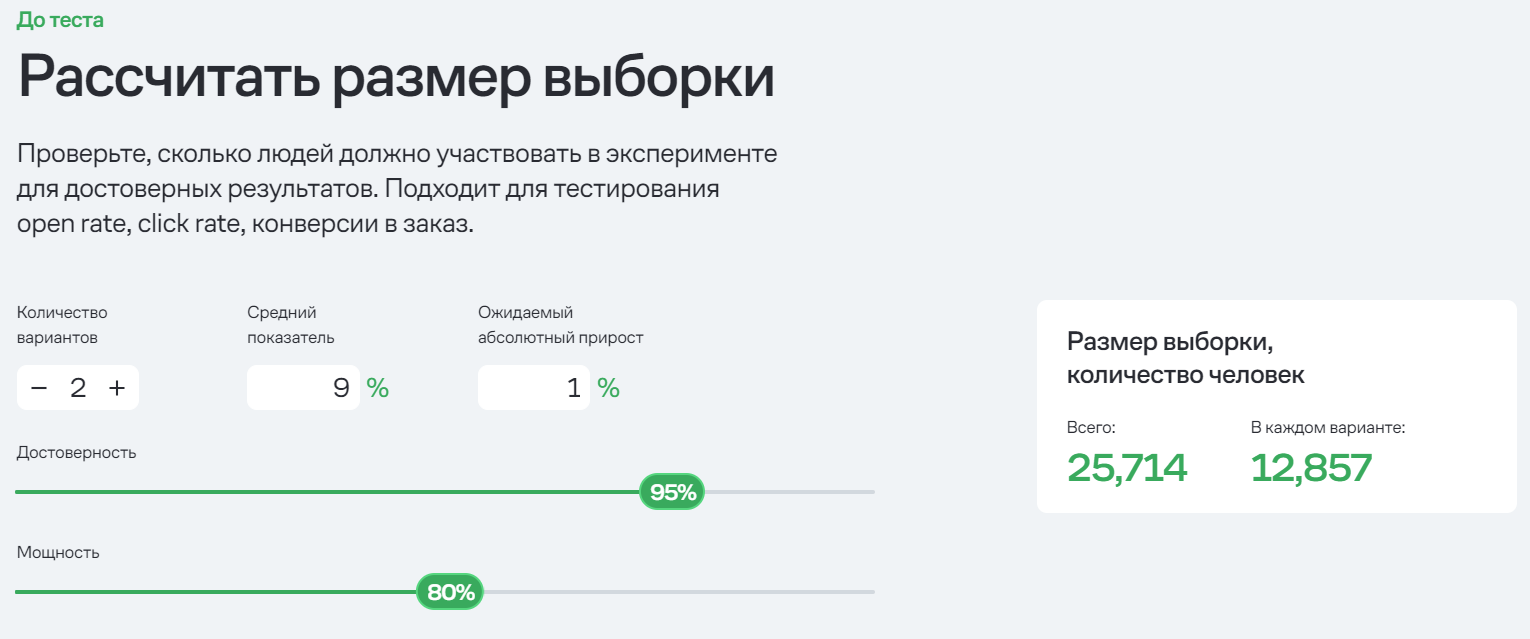

__Вывод:__ Судя по всему нам хватает текущего количества наблюдений.

<div class="alert alert-success">
В результате проведенного эксперимента получили стат. значимое (на уровне значимости 5%) увеличение конверсии из просмотра в донат для разовых пожертвований при сохранении доли разовых пожертовований от всех (стат. значимых различий на уровне значимости 5% не нашли). Можно сделать вывод, что отсутствие предзаполенного положительно влияет на желание пользователя сделать пожертвование.<br/>
<br/>
Но в это же время мы получили небольшое, но стат. значимое снижение средней суммы этих пожертвований (на уровне значимости 5%). А это уже негативная тенденция.<br/>
<br/>
Поэтому я бы рекомендовал не раскатывать это изменение сразу (полностью убирать предзаполненную сумму), а попробовать провести доп. эксперименты с разными значением этой предзаполненной суммы. В идеале нам нужно получить стат. значимое увеличение конверсии в донат, но не снизить средний размер этих донатов.
</div>